In [1]:
pip install pvlib

Note: you may need to restart the kernel to use updated packages.


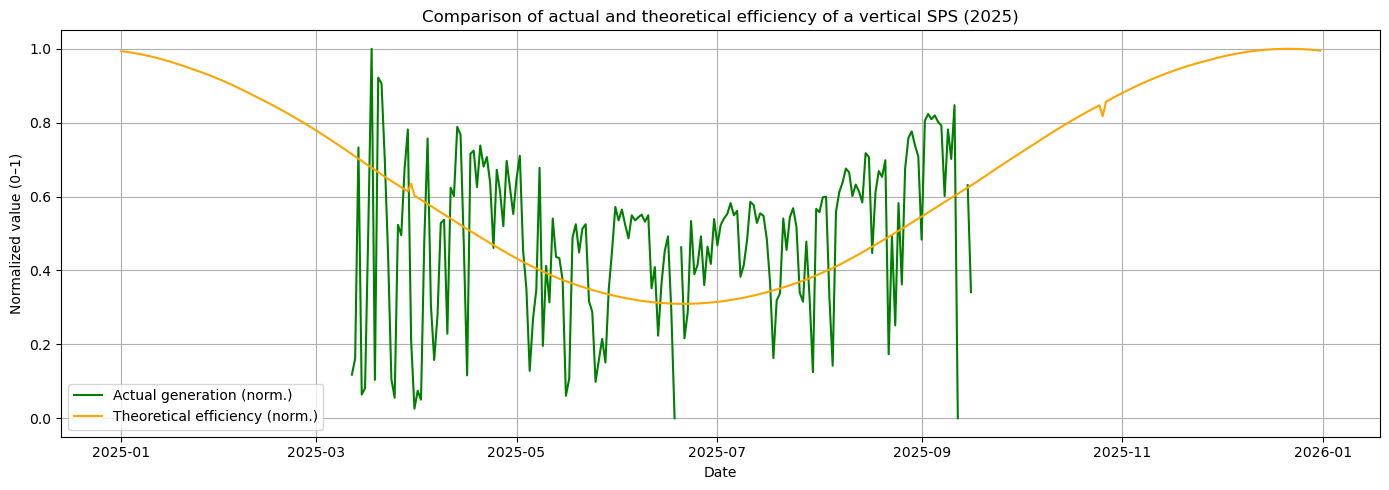

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pvlib.location import Location
import pvlib

# === 1. Завантаження даних з Excel ===
df = pd.read_excel(r'C:\Users\ypohr\OneDrive\Рабочий стол\Data Analytics\SPS_project\SPS10kW_Stat_main.xlsx')
df['Date'] = pd.to_datetime(df['Date'])
df = df[['Date', 'Daily production (kWh)']]
df.columns = ['Date', 'actual_kWh']
df = df.set_index('Date')

# Заповнення пустих днів
full_dates = pd.date_range('2025-01-01', '2025-12-31', freq='D')
df = df.reindex(full_dates)
df.index.name = 'Date'
full_dates


# === 2. Теоретична ефективність (cos(AOI)) ===
# AOI (numeric) – Angle of incidence in degrees
# AOI - is the angle between the solar vector and the surface normal

times = pd.date_range('2025-01-01', '2025-12-31 23:00', freq='1h', tz='Europe/Kyiv')
location = Location(latitude=50.45, longitude=30.52, tz='Europe/Kyiv')

solar_position = location.get_solarposition(times)
aoi = pvlib.irradiance.aoi(
    surface_tilt=90,
    surface_azimuth=180,
    solar_zenith=solar_position['apparent_zenith'],
    solar_azimuth=solar_position['azimuth']
)

efficiency = np.cos(np.radians(aoi))
efficiency[efficiency < 0] = 0

df_eff = pd.DataFrame({'efficiency': efficiency}, index=times)
daily_theory = df_eff.resample('D').mean()

# === 3. Об'єднання та нормалізація ===

# Видаляємо тайм-зони із датафрейму
daily_theory = daily_theory.tz_localize(None)

# Джойнимо DataFrames
df = df.join(daily_theory)
df['actual_norm'] = df['actual_kWh'] / df['actual_kWh'].max()
df['theory_norm'] = df['efficiency'] / df['efficiency'].max()

# === 4. Побудова графіка ===
plt.figure(figsize=(14, 5))
plt.plot(df.index, df['actual_norm'], label='Actual generation (norm.)', color='green')
plt.plot(df.index, df['theory_norm'], label='Theoretical efficiency (norm.)', color='orange')
plt.title('Comparison of actual and theoretical efficiency of a vertical SPS (2025)')
plt.xlabel('Date')
plt.ylabel('Normalized value (0–1)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [3]:
# === 5. Формування CSV для Tableau ===
df_export = df[['actual_kWh', 'efficiency', 'actual_norm', 'theory_norm']].copy()
df_export = df_export.reset_index()  # Date робимо звичайну колонку
export_path = "Kyiv_actual_theory_norm_2025.xlsx"
df_export.to_excel(export_path, index=False)

export_path

'Kyiv_actual_theory_norm_2025.xlsx'